In [119]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import re
import os
from sklearn.model_selection import train_test_split
import random
import gc
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv("international-airline-passengers.csv")

In [191]:
seed = 1
learning_rate = 0.001
batch_size = 10
n_epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
data.columns = ["Month", "Num"]

In [135]:
mean = data.Num.mean()
std = data.Num.std()
data.Num = (data.Num-mean)/std

In [9]:
def create_df (df, window):
    data_x = []
    data_y = []
    for i in range(len(df)-window+1):
        data_x.append(df[i:i+window])
        data_y.append(df[i+window-1])
    return np.asarray(data_x), np.asarray(data_y)

In [136]:
train_X, train_Y = create_df(data.Num, 3)

In [137]:
x_train,x_test,y_train,y_test = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

In [139]:
trainfoldx = torch.tensor(x_train, dtype=torch.float32).to(device)
trainfoldy = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val_fold = torch.tensor(x_test, dtype=torch.float32).to(device)
y_val_fold = torch.tensor(y_test[:,np.newaxis], dtype=torch.float32).to(device)

train = torch.utils.data.TensorDataset(trainfoldx,trainfoldy)
valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

train_loader = torch.utils.data.DataLoader(train , batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [159]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([50, 3])
Image label dimensions: torch.Size([50])


In [194]:
### Change here ###
class RNN(torch.nn.Module):

    def __init__(self):
        super(RNN,self).__init__() 
        self.lstm = nn.LSTM(1,6,2, batch_first = True) # input_size hidden_size num_layers
        self.fc1 = nn.Linear(6,1) 
    def forward(self,x):
        x = x.unsqueeze(2)
#         print(x.shape)
        packed_output, (hidden, cell) = self.lstm(x) # batch, seq_len, input_size (feature)
        packed_output = packed_output[:, -1, :]
#         print(packed_output.shape)
        hidden = self.fc1(packed_output)
        return hidden

In [172]:
def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    loss_fn=torch.nn.MSELoss()
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)   
            targets = targets.to(device)
            logits = model.forward(features)
#             print(logits.shape)
            loss = loss_fn(torch.squeeze(logits),targets)
            num_examples += targets.size()[0]
            curr_loss += loss*targets.size()[0]         ### MSEloss is an average loss. ###

        curr_loss = curr_loss / num_examples
        return curr_loss

In [195]:
train_cost = []
test_cost=[]
start_time = time.time()
minibatch_cost = []
torch.manual_seed(seed)
model = RNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-8)  ### Change here for different optimizer ###
loss_fn = torch.nn.MSELoss()                    ### Change here for different loss function ###
for epoch in range(n_epochs):
    start = time.time()
    model.train()
    grand_loss = 0
    for  batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        logits = model(x_batch)
#         print(logits.shape)
        loss=loss_fn(torch.squeeze(logits),y_batch)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not batch_idx % 2:                    
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                %(epoch+1, n_epochs, batch_idx, len(train_loader), math.sqrt(loss.item())))

                  #evaluation          
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    cost_test = compute_epoch_loss(model, valid_loader)
    train_cost.append(cost.item())
    test_cost.append(cost_test.item())
    

    print('Epoch: %03d/%03d Train Cost: %.4f Test Cost: %.4f' % (
            epoch+1, n_epochs, math.sqrt(cost),math.sqrt(cost_test)))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/500 | Batch 000/003 | Loss: 0.9904
Epoch: 001/500 | Batch 002/003 | Loss: 0.6524
Epoch: 001/500 Train Cost: 1.0400 Test Cost: 0.9774
Time elapsed: 0.00 min
Epoch: 002/500 | Batch 000/003 | Loss: 1.1156
Epoch: 002/500 | Batch 002/003 | Loss: 0.5206
Epoch: 002/500 Train Cost: 1.0378 Test Cost: 0.9767
Time elapsed: 0.00 min
Epoch: 003/500 | Batch 000/003 | Loss: 1.1378
Epoch: 003/500 | Batch 002/003 | Loss: 0.8673
Epoch: 003/500 Train Cost: 1.0350 Test Cost: 0.9757
Time elapsed: 0.00 min
Epoch: 004/500 | Batch 000/003 | Loss: 0.9984
Epoch: 004/500 | Batch 002/003 | Loss: 0.7158
Epoch: 004/500 Train Cost: 1.0321 Test Cost: 0.9747
Time elapsed: 0.00 min
Epoch: 005/500 | Batch 000/003 | Loss: 1.0601
Epoch: 005/500 | Batch 002/003 | Loss: 0.9499
Epoch: 005/500 Train Cost: 1.0293 Test Cost: 0.9738
Time elapsed: 0.01 min
Epoch: 006/500 | Batch 000/003 | Loss: 1.0272
Epoch: 006/500 | Batch 002/003 | Loss: 0.5750
Epoch: 006/500 Train Cost: 1.0265 Test Cost: 0.9730
Time elapsed: 0.01 mi

Epoch: 050/500 | Batch 000/003 | Loss: 0.7562
Epoch: 050/500 | Batch 002/003 | Loss: 0.5865
Epoch: 050/500 Train Cost: 0.6631 Test Cost: 1.0419
Time elapsed: 0.05 min
Epoch: 051/500 | Batch 000/003 | Loss: 0.6421
Epoch: 051/500 | Batch 002/003 | Loss: 0.8763
Epoch: 051/500 Train Cost: 0.6423 Test Cost: 1.0513
Time elapsed: 0.05 min
Epoch: 052/500 | Batch 000/003 | Loss: 0.5749
Epoch: 052/500 | Batch 002/003 | Loss: 0.7507
Epoch: 052/500 Train Cost: 0.6204 Test Cost: 1.0623
Time elapsed: 0.05 min
Epoch: 053/500 | Batch 000/003 | Loss: 0.5620
Epoch: 053/500 | Batch 002/003 | Loss: 0.5028
Epoch: 053/500 Train Cost: 0.5984 Test Cost: 1.0740
Time elapsed: 0.05 min
Epoch: 054/500 | Batch 000/003 | Loss: 0.6104
Epoch: 054/500 | Batch 002/003 | Loss: 0.5929
Epoch: 054/500 Train Cost: 0.5771 Test Cost: 1.0862
Time elapsed: 0.05 min
Epoch: 055/500 | Batch 000/003 | Loss: 0.5623
Epoch: 055/500 | Batch 002/003 | Loss: 0.6812
Epoch: 055/500 Train Cost: 0.5566 Test Cost: 1.0991
Time elapsed: 0.05 mi

Epoch: 099/500 | Batch 000/003 | Loss: 0.3963
Epoch: 099/500 | Batch 002/003 | Loss: 0.2131
Epoch: 099/500 Train Cost: 0.3712 Test Cost: 1.2950
Time elapsed: 0.09 min
Epoch: 100/500 | Batch 000/003 | Loss: 0.3556
Epoch: 100/500 | Batch 002/003 | Loss: 0.6102
Epoch: 100/500 Train Cost: 0.3705 Test Cost: 1.2971
Time elapsed: 0.09 min
Epoch: 101/500 | Batch 000/003 | Loss: 0.3854
Epoch: 101/500 | Batch 002/003 | Loss: 0.2181
Epoch: 101/500 Train Cost: 0.3694 Test Cost: 1.3001
Time elapsed: 0.09 min
Epoch: 102/500 | Batch 000/003 | Loss: 0.3725
Epoch: 102/500 | Batch 002/003 | Loss: 0.3242
Epoch: 102/500 Train Cost: 0.3685 Test Cost: 1.3021
Time elapsed: 0.09 min
Epoch: 103/500 | Batch 000/003 | Loss: 0.3990
Epoch: 103/500 | Batch 002/003 | Loss: 0.5840
Epoch: 103/500 Train Cost: 0.3676 Test Cost: 1.3035
Time elapsed: 0.10 min
Epoch: 104/500 | Batch 000/003 | Loss: 0.3982
Epoch: 104/500 | Batch 002/003 | Loss: 0.4054
Epoch: 104/500 Train Cost: 0.3662 Test Cost: 1.3061
Time elapsed: 0.10 mi

Epoch: 148/500 | Batch 000/003 | Loss: 0.3495
Epoch: 148/500 | Batch 002/003 | Loss: 0.1930
Epoch: 148/500 Train Cost: 0.3237 Test Cost: 1.3381
Time elapsed: 0.14 min
Epoch: 149/500 | Batch 000/003 | Loss: 0.2728
Epoch: 149/500 | Batch 002/003 | Loss: 0.2816
Epoch: 149/500 Train Cost: 0.3221 Test Cost: 1.3369
Time elapsed: 0.14 min
Epoch: 150/500 | Batch 000/003 | Loss: 0.3034
Epoch: 150/500 | Batch 002/003 | Loss: 0.3573
Epoch: 150/500 Train Cost: 0.3207 Test Cost: 1.3335
Time elapsed: 0.14 min
Epoch: 151/500 | Batch 000/003 | Loss: 0.2797
Epoch: 151/500 | Batch 002/003 | Loss: 0.2703
Epoch: 151/500 Train Cost: 0.3204 Test Cost: 1.3297
Time elapsed: 0.14 min
Epoch: 152/500 | Batch 000/003 | Loss: 0.3020
Epoch: 152/500 | Batch 002/003 | Loss: 0.1942
Epoch: 152/500 Train Cost: 0.3200 Test Cost: 1.3289
Time elapsed: 0.14 min
Epoch: 153/500 | Batch 000/003 | Loss: 0.2873
Epoch: 153/500 | Batch 002/003 | Loss: 0.2450
Epoch: 153/500 Train Cost: 0.3191 Test Cost: 1.3285
Time elapsed: 0.14 mi

Epoch: 197/500 | Batch 000/003 | Loss: 0.3188
Epoch: 197/500 | Batch 002/003 | Loss: 0.3002
Epoch: 197/500 Train Cost: 0.2730 Test Cost: 1.3488
Time elapsed: 0.18 min
Epoch: 198/500 | Batch 000/003 | Loss: 0.2633
Epoch: 198/500 | Batch 002/003 | Loss: 0.1875
Epoch: 198/500 Train Cost: 0.2721 Test Cost: 1.3496
Time elapsed: 0.18 min
Epoch: 199/500 | Batch 000/003 | Loss: 0.2840
Epoch: 199/500 | Batch 002/003 | Loss: 0.2057
Epoch: 199/500 Train Cost: 0.2716 Test Cost: 1.3513
Time elapsed: 0.18 min
Epoch: 200/500 | Batch 000/003 | Loss: 0.2388
Epoch: 200/500 | Batch 002/003 | Loss: 0.5149
Epoch: 200/500 Train Cost: 0.2719 Test Cost: 1.3537
Time elapsed: 0.18 min
Epoch: 201/500 | Batch 000/003 | Loss: 0.2459
Epoch: 201/500 | Batch 002/003 | Loss: 0.1568
Epoch: 201/500 Train Cost: 0.2719 Test Cost: 1.3574
Time elapsed: 0.18 min
Epoch: 202/500 | Batch 000/003 | Loss: 0.2651
Epoch: 202/500 | Batch 002/003 | Loss: 0.1569
Epoch: 202/500 Train Cost: 0.2702 Test Cost: 1.3603
Time elapsed: 0.19 mi

Epoch: 246/500 | Batch 000/003 | Loss: 0.1860
Epoch: 246/500 | Batch 002/003 | Loss: 0.0827
Epoch: 246/500 Train Cost: 0.2134 Test Cost: 1.3728
Time elapsed: 0.22 min
Epoch: 247/500 | Batch 000/003 | Loss: 0.2169
Epoch: 247/500 | Batch 002/003 | Loss: 0.2996
Epoch: 247/500 Train Cost: 0.2116 Test Cost: 1.3731
Time elapsed: 0.23 min
Epoch: 248/500 | Batch 000/003 | Loss: 0.2178
Epoch: 248/500 | Batch 002/003 | Loss: 0.1418
Epoch: 248/500 Train Cost: 0.2106 Test Cost: 1.3760
Time elapsed: 0.23 min
Epoch: 249/500 | Batch 000/003 | Loss: 0.1853
Epoch: 249/500 | Batch 002/003 | Loss: 0.2227
Epoch: 249/500 Train Cost: 0.2094 Test Cost: 1.3771
Time elapsed: 0.23 min
Epoch: 250/500 | Batch 000/003 | Loss: 0.2260
Epoch: 250/500 | Batch 002/003 | Loss: 0.1386
Epoch: 250/500 Train Cost: 0.2086 Test Cost: 1.3806
Time elapsed: 0.23 min
Epoch: 251/500 | Batch 000/003 | Loss: 0.2125
Epoch: 251/500 | Batch 002/003 | Loss: 0.2855
Epoch: 251/500 Train Cost: 0.2071 Test Cost: 1.3816
Time elapsed: 0.23 mi

Epoch: 295/500 | Batch 000/003 | Loss: 0.1441
Epoch: 295/500 | Batch 002/003 | Loss: 0.1471
Epoch: 295/500 Train Cost: 0.1513 Test Cost: 1.3643
Time elapsed: 0.27 min
Epoch: 296/500 | Batch 000/003 | Loss: 0.1738
Epoch: 296/500 | Batch 002/003 | Loss: 0.1009
Epoch: 296/500 Train Cost: 0.1500 Test Cost: 1.3636
Time elapsed: 0.27 min
Epoch: 297/500 | Batch 000/003 | Loss: 0.1460
Epoch: 297/500 | Batch 002/003 | Loss: 0.1163
Epoch: 297/500 Train Cost: 0.1483 Test Cost: 1.3642
Time elapsed: 0.27 min
Epoch: 298/500 | Batch 000/003 | Loss: 0.1268
Epoch: 298/500 | Batch 002/003 | Loss: 0.1211
Epoch: 298/500 Train Cost: 0.1468 Test Cost: 1.3659
Time elapsed: 0.27 min
Epoch: 299/500 | Batch 000/003 | Loss: 0.1364
Epoch: 299/500 | Batch 002/003 | Loss: 0.1475
Epoch: 299/500 Train Cost: 0.1456 Test Cost: 1.3673
Time elapsed: 0.27 min
Epoch: 300/500 | Batch 000/003 | Loss: 0.1250
Epoch: 300/500 | Batch 002/003 | Loss: 0.1131
Epoch: 300/500 Train Cost: 0.1445 Test Cost: 1.3677
Time elapsed: 0.27 mi

Epoch: 344/500 | Batch 000/003 | Loss: 0.0941
Epoch: 344/500 | Batch 002/003 | Loss: 0.0716
Epoch: 344/500 Train Cost: 0.0999 Test Cost: 1.3700
Time elapsed: 0.31 min
Epoch: 345/500 | Batch 000/003 | Loss: 0.1147
Epoch: 345/500 | Batch 002/003 | Loss: 0.0741
Epoch: 345/500 Train Cost: 0.0985 Test Cost: 1.3723
Time elapsed: 0.31 min
Epoch: 346/500 | Batch 000/003 | Loss: 0.1096
Epoch: 346/500 | Batch 002/003 | Loss: 0.1170
Epoch: 346/500 Train Cost: 0.0975 Test Cost: 1.3754
Time elapsed: 0.32 min
Epoch: 347/500 | Batch 000/003 | Loss: 0.0916
Epoch: 347/500 | Batch 002/003 | Loss: 0.0792
Epoch: 347/500 Train Cost: 0.0979 Test Cost: 1.3781
Time elapsed: 0.32 min
Epoch: 348/500 | Batch 000/003 | Loss: 0.1071
Epoch: 348/500 | Batch 002/003 | Loss: 0.0890
Epoch: 348/500 Train Cost: 0.0975 Test Cost: 1.3774
Time elapsed: 0.32 min
Epoch: 349/500 | Batch 000/003 | Loss: 0.0930
Epoch: 349/500 | Batch 002/003 | Loss: 0.0845
Epoch: 349/500 Train Cost: 0.0961 Test Cost: 1.3750
Time elapsed: 0.32 mi

Epoch: 393/500 | Batch 000/003 | Loss: 0.0585
Epoch: 393/500 | Batch 002/003 | Loss: 0.0495
Epoch: 393/500 Train Cost: 0.0738 Test Cost: 1.3695
Time elapsed: 0.36 min
Epoch: 394/500 | Batch 000/003 | Loss: 0.0549
Epoch: 394/500 | Batch 002/003 | Loss: 0.0666
Epoch: 394/500 Train Cost: 0.0741 Test Cost: 1.3724
Time elapsed: 0.36 min
Epoch: 395/500 | Batch 000/003 | Loss: 0.0820
Epoch: 395/500 | Batch 002/003 | Loss: 0.0615
Epoch: 395/500 Train Cost: 0.0738 Test Cost: 1.3736
Time elapsed: 0.36 min
Epoch: 396/500 | Batch 000/003 | Loss: 0.0710
Epoch: 396/500 | Batch 002/003 | Loss: 0.1545
Epoch: 396/500 Train Cost: 0.0730 Test Cost: 1.3739
Time elapsed: 0.36 min
Epoch: 397/500 | Batch 000/003 | Loss: 0.0858
Epoch: 397/500 | Batch 002/003 | Loss: 0.0521
Epoch: 397/500 Train Cost: 0.0730 Test Cost: 1.3768
Time elapsed: 0.36 min
Epoch: 398/500 | Batch 000/003 | Loss: 0.0771
Epoch: 398/500 | Batch 002/003 | Loss: 0.1043
Epoch: 398/500 Train Cost: 0.0728 Test Cost: 1.3773
Time elapsed: 0.36 mi

Epoch: 442/500 | Batch 000/003 | Loss: 0.0552
Epoch: 442/500 | Batch 002/003 | Loss: 0.0580
Epoch: 442/500 Train Cost: 0.0655 Test Cost: 1.3632
Time elapsed: 0.40 min
Epoch: 443/500 | Batch 000/003 | Loss: 0.0533
Epoch: 443/500 | Batch 002/003 | Loss: 0.0504
Epoch: 443/500 Train Cost: 0.0641 Test Cost: 1.3650
Time elapsed: 0.40 min
Epoch: 444/500 | Batch 000/003 | Loss: 0.0587
Epoch: 444/500 | Batch 002/003 | Loss: 0.0494
Epoch: 444/500 Train Cost: 0.0632 Test Cost: 1.3678
Time elapsed: 0.40 min
Epoch: 445/500 | Batch 000/003 | Loss: 0.0577
Epoch: 445/500 | Batch 002/003 | Loss: 0.0958
Epoch: 445/500 Train Cost: 0.0629 Test Cost: 1.3684
Time elapsed: 0.41 min
Epoch: 446/500 | Batch 000/003 | Loss: 0.0720
Epoch: 446/500 | Batch 002/003 | Loss: 0.0376
Epoch: 446/500 Train Cost: 0.0631 Test Cost: 1.3666
Time elapsed: 0.41 min
Epoch: 447/500 | Batch 000/003 | Loss: 0.0512
Epoch: 447/500 | Batch 002/003 | Loss: 0.0641
Epoch: 447/500 Train Cost: 0.0630 Test Cost: 1.3662
Time elapsed: 0.41 mi

Epoch: 491/500 | Batch 000/003 | Loss: 0.0477
Epoch: 491/500 | Batch 002/003 | Loss: 0.0267
Epoch: 491/500 Train Cost: 0.0566 Test Cost: 1.3729
Time elapsed: 0.45 min
Epoch: 492/500 | Batch 000/003 | Loss: 0.0528
Epoch: 492/500 | Batch 002/003 | Loss: 0.0425
Epoch: 492/500 Train Cost: 0.0567 Test Cost: 1.3737
Time elapsed: 0.45 min
Epoch: 493/500 | Batch 000/003 | Loss: 0.0621
Epoch: 493/500 | Batch 002/003 | Loss: 0.0572
Epoch: 493/500 Train Cost: 0.0559 Test Cost: 1.3706
Time elapsed: 0.45 min
Epoch: 494/500 | Batch 000/003 | Loss: 0.0517
Epoch: 494/500 | Batch 002/003 | Loss: 0.0853
Epoch: 494/500 Train Cost: 0.0556 Test Cost: 1.3663
Time elapsed: 0.45 min
Epoch: 495/500 | Batch 000/003 | Loss: 0.0500
Epoch: 495/500 | Batch 002/003 | Loss: 0.0565
Epoch: 495/500 Train Cost: 0.0556 Test Cost: 1.3657
Time elapsed: 0.45 min
Epoch: 496/500 | Batch 000/003 | Loss: 0.0500
Epoch: 496/500 | Batch 002/003 | Loss: 0.1147
Epoch: 496/500 Train Cost: 0.0556 Test Cost: 1.3660
Time elapsed: 0.45 mi

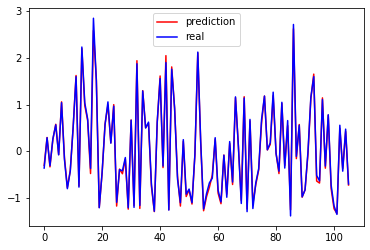

In [196]:
dataX1 = x_train
dataX2 = torch.tensor(dataX1, dtype=torch.float32).to(device)

pred = model.forward(dataX2).cpu()

pred_test = pred.view(-1).data.numpy()  

plt.plot(pred.view(-1).data.numpy(), 'r', label='prediction')
plt.plot(y_train, 'b', label='real')
plt.legend(loc='best')